In [ ]:
!pip install tf-nightly-gpu==2.6.0.dev20210504


     |████████████████████████████████| 452.9 MB 8.1 kB/s 
     |████████████████████████████████| 462 kB 41.4 MB/s 
     |████████████████████████████████| 5.5 MB 24.6 MB/s 
     |████████████████████████████████| 1.3 MB 34.2 MB/s 
     |████████████████████████████████| 4.3 MB 31.3 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: keras-nightly
    Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling keras-nightly-2.5.0.dev2021032900:
      Successfully uninstalled keras-nightly-2.5.0.dev2021032900
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires grpcio~=1.34.0, but you have grpcio 1.39.0 which is incompatible.
tensorflow 2.5.0 requires keras-nightly~=2.5.0.dev, but you have 

In [ ]:
# import keras

In [ ]:
!pip install onnx

     |████████████████████████████████| 12.2 MB 250 kB/s 


In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6253, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 6253 (delta 134), reused 84 (delta 58), pack-reused 6051
Receiving objects: 100% (6253/6253), 1.93 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (4859/4859), done.


In [ ]:
%cd onnx-tensorflow

/content/onnx-tensorflow


In [ ]:
# from tensorflow import keras

In [ ]:
# pip install tensorflow-addons

     |████████████████████████████████| 679 kB 8.0 MB/s 


In [ ]:
!pip install -e .

Obtaining file:///content/onnx-tensorflow
     |████████████████████████████████| 679 kB 8.4 MB/s 
  Running setup.py develop for onnx-tf


In [ ]:
from onnx_tf.backend import prepare

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210504). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [ ]:
%cd /content

/content


In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import torch.onnx
import numpy as np
from pagemobilenet import mobilenet_v2
import onnx
# from onnx_tf.backend import prepare
import tensorflow as tf
from PIL import Image

ONNX_PATH="./mob.onnx"

input_chan_layer = 16
last_chan_layer = 16
P_DROPOUT = 0.45
num_classes = 2
inp_path = "/content/pagemodel_patchsize=120_pagesize=512x396.pt"

input_size = [512, 396]
patch_siz = 120
center_coord = [int((t - patch_siz)*0.5) for t in input_size]


# inp_size = 400
# quant = False

mob = mobilenet_v2(pretrained = False, input_channel = input_chan_layer, last_channel = last_chan_layer,
                   crop_pat_size=patch_siz, crop_cen_h=center_coord[0], crop_cen_w=center_coord[1])
# mob = mobilenet_v2(pretrained = False)
mob.classifier[0] = nn.Dropout(P_DROPOUT)
mob.classifier[1] = nn.Linear(in_features = last_chan_layer, out_features = num_classes)
# mob.classifier[1] = nn.Linear(in_features = 128, out_features = num_classes)
mob_wts = torch.load(inp_path, map_location='cuda:0')
mob.load_state_dict(mob_wts)
mob.eval()

x = torch.randn(1, 3, 512, 396, requires_grad=True)

torch_out = torch.onnx._export(mob, x, "mob.onnx", export_params=True, input_names=['input'],
                                output_names=['output'], opset_version = 11)
onnx_model = onnx.load("mob.onnx")
onnx.checker.check_model(onnx_model)

TF_PATH = "./tf_mob.pb" # where the representation of tensorflow model will be stored
ONNX_PATH = "./mob.onnx" # path to my existing ONNX model
onnx_model = onnx.load(ONNX_PATH)  # load onnx model

# prepare function converts an ONNX model to an internel representation
# of the computational graph called TensorflowRep and returns
# the converted representation.
tf_rep = prepare(onnx_model)  # creating TensorflowRep object

# export_graph function obtains the graph proto corresponding to the ONNX
# model associated with the backend representation and serializes
# to a protobuf file.
tf_rep.export_graph(TF_PATH)

for quant in [False, True]:
  if quant:
    out_path = inp_path.rpartition(".")[0] + "_quant.tflite"
  else:
    out_path = inp_path.rpartition(".")[0]  + ".tflite"

  converter = tf.lite.TFLiteConverter.from_saved_model("tf_mob.pb")
  if quant: converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                        tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]
  tflite_model = converter.convert()

  with open(out_path, 'wb') as f:
      f.write(tflite_model)

/content/pagemobilenet.py:30: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  #     mean_ = torch.as_tensor([0.485, 0.456, 0.406], dtype = x_.dtype, device = x_.device).view(1, -1, 1, 1).repeat((x_.shape[0], 1, 1, 1))
/content/pagemobilenet.py:31: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  #     std_ = torch.as_tensor([0.229, 0.224, 0.225], dtype = x_.dtype, device = x_.device).view(1, -1, 1, 1).repeat((x_.shape[0], 1, 1, 1))


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


INFO:tensorflow:Assets written to: ./tf_mob.pb/assets


INFO:tensorflow:Assets written to: ./tf_mob.pb/assets


In [ ]:
import tensorflow as tf
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    model_filename ='PATH_TO_PB.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
LOGDIR='YOUR_LOG_LOCATION'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

AttributeError: ignored

In [ ]:
!wget https://raw.githubusercontent.com/ltn100/tensorflow/feature/LN/fix_import_pb_to_tensorboard/tensorflow/python/tools/import_pb_to_tensorboard.py


--2021-02-03 13:32:11--  https://raw.githubusercontent.com/ltn100/tensorflow/feature/LN/fix_import_pb_to_tensorboard/tensorflow/python/tools/import_pb_to_tensorboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3475 (3.4K) [text/plain]
Saving to: ‘import_pb_to_tensorboard.py’

import_pb_to_tensor 100%[===================>]   3.39K  --.-KB/s    in 0s      

2021-02-03 13:32:11 (45.3 MB/s) - ‘import_pb_to_tensorboard.py’ saved [3475/3475]



In [ ]:
!python import_pb_to_tensorboard.py --model_dir tf_mob.pb/ --log_dir logs


2021-02-03 13:32:49.331296: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-02-03 13:32:49.331338: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-02-03 13:32:50.722805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-03 13:32:50.727074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-03 13:32:50.727640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1770] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 dev

In [ ]:
%tensorboad --

In [ ]:
from google.colab import files

files.download("mob_new-data_e2e_quant.tflite")

In [ ]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [ ]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init

In [ ]:
import onnx

In [ ]:
ONNX_PATH="./mob_small.onnx"

In [ ]:
from mobilenet import mobilenet_v2

mob = mobilenet_v2(pretrained = False)
mob.classifier[0] = nn.Dropout(0.45)
mob.classifier[1] = nn.Linear(in_features = 96, out_features = 2)

mob_wts = torch.load("mob_perpage_200_new.pt")

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
mob.load_state_dict(mob_wts)

<All keys matched successfully>

In [ ]:
mob.eval()

In [ ]:
# Input to the model
x = torch.randn(1, 3, 200, 200, requires_grad=True)

# Export the model
torch_out = torch.onnx._export(mob,             # model being run
                               x,                       # model input (or a tuple for multiple inputs)
                               "mob_onnx.onnx", # where to save the model (can be a file or file-like object)
                               export_params=True,
                               input_names=['input'],
                                output_names=['output'])      # store the trained parameter weights inside the model file
onnx_model = onnx.load("mob_onnx.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
from onnx_tf.backend import prepare
import onnx

In [ ]:
TF_PATH = "./tf_mob.pb" # where the representation of tensorflow model will be stored
ONNX_PATH = "./mob_onnx.onnx" # path to my existing ONNX model
onnx_model = onnx.load(ONNX_PATH)  # load onnx model

# prepare function converts an ONNX model to an internel representation
# of the computational graph called TensorflowRep and returns
# the converted representation.
tf_rep = prepare(onnx_model)  # creating TensorflowRep object

# export_graph function obtains the graph proto corresponding to the ONNX
# model associated with the backend representation and serializes
# to a protobuf file.
tf_rep.export_graph(TF_PATH)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


INFO:tensorflow:Assets written to: ./tf_mob.pb/assets


INFO:tensorflow:Assets written to: ./tf_mob.pb/assets


In [ ]:
import tensorflow as tf

In [ ]:
# TF_PATH = "./tf_mob.pb/saved_model.pb" # where the forzen graph is stored
# TFLITE_PATH = "./mob_lite.tflite"
# # protopuf needs your virtual environment to be explictly exported in the path
# # os.environ["PATH"] = "/opt/miniconda3/envs/convert/bin:/opt/miniconda3/bin:/usr/local/sbin:...."

# # make a converter object from the saved tensorflow file
# # converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(TF_PATH,  # TensorFlow freezegraph .pb model file
# #                                                       input_arrays=['input'], # name of input arrays as defined in torch.onnx.export function before.
# #                                                       output_arrays=['output'] # name of output arrays defined in torch.onnx.export function before.
# #                                                       )

# converter = tf.lite.TFLiteConverter.from_frozen_graph(TF_PATH,
#                                                       input_arrays = ['input'])

# # tell converter which type of optimization techniques to use
# # to view the best option for optimization read documentation of tflite about optimization
# # go to this link https://www.tensorflow.org/lite/guide/get_started#4_optimize_your_model_optional
# # converter.optimizations = [tf.compat.v1.lite.Optimize.DEFAULT]

# converter.experimental_new_converter = True

# # I had to explicitly state the ops
# converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
#                                        tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]

# tf_lite_model = converter.convert()
# # Save the model.
# with open(TFLITE_PATH, 'wb') as f:
#     f.write(tf_lite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("tf_mob_B.pb") # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

In [ ]:
with open('model_smaller_B_v2_quant.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
inp_vals = np.load("inps_np.npy")
lab_vals = torch.load("labs.pt").detach().numpy()

FileNotFoundError: ignored

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("tf_mob.pb")
# converter.optimizations = [tf.compat.v1.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

with open('model_perpage200_v1_drop.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("tf_mob.pb")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

with open('model_perpage200_v1_drop_quant.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# # import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_saved_model("tf_mob.pb")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
#                                        tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]
# tflite_quant_model = converter.convert()

In [ ]:
# with open('model_quant_ops.tflite', 'wb') as f:
#   f.write(tflite_quant_model)

In [ ]:
import tensorflow as tf
import numpy as np

TFLITE_PATH = "model_150_v1quant.tflite"

# 0 -- Latin, 1 -- Non-latin
# this is code when inp_vals has shape (64, 3, 224, 224) and lab_vals (64,)

interpreter = tf.compat.v1.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
avg = []
for i in range(0, len(x)):
  interpreter.set_tensor(input_details[0]['index'],[x[i]])
  interpreter.invoke()
  preds = interpreter.get_tensor(output_details[0]['index'])
  avg.append(np.sum(np.argmax(preds, axis = 1) == lab_vals[i]))

____________________

In [ ]:
from torchvision import transforms
input_size = 224
trans = transforms.Compose([transforms.Resize(input_size),
                            # transforms.CenterCrop(input_size),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
np.mean((till_tens - np.mean(till_tens, axis = (0, 1))) / np.std(till_tens, axis = (0, 1)), axis = (0, 1))

array([-1.01455544e-13, -1.01455544e-13, -1.01455544e-13])

In [ ]:
x[0][0], till_tens[0]

(array([[2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083],
        ...,
        [2.2489083, 2.2489083, 1.5810429, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.1804092, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083]], dtype=float32),
 array([[2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.2489083, ..., 1.5467933, 1.9749122,
         2.2489083],
        ...,
        [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
         2.2489083],
        [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083,

In [ ]:
x[0].shape, till_tens.shape

((3, 224, 224), (3, 224, 224))

In [ ]:
till_tens = np.array(transforms.Compose([transforms.Resize(input_size),
                            #  transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])(y[0]))

In [ ]:
tens = []
for y_im in y:
  tens.append(trans(y_im))

In [ ]:
y_new = torch.stack(tens).numpy()

In [ ]:
!unzip LD.zip

Archive:  LD.zip
   creating: LD/
   creating: LD/LaTIN/
   creating: LD/NON-LATIN/
  inflating: LD/LaTIN/E0SNNRW03-4_4.png  
  inflating: LD/LaTIN/E0SNNRW03-4_5.png  
  inflating: LD/LaTIN/E0SNNRW03-4_2.png  
  inflating: LD/LaTIN/E0SNNRW03-4_3.png  
  inflating: LD/LaTIN/E0SNNRW03-4_1.png  
  inflating: LD/LaTIN/E0SNNRW03-4_0.png  
  inflating: LD/NON-LATIN/Arabic_ACTIVITE-IND_Page_19_0.png  
  inflating: LD/NON-LATIN/Korean_saigaipanf_k_Page_18_2.png  
  inflating: LD/NON-LATIN/Japanese_36496_ext_18_0_Page_44_1.png  
  inflating: LD/NON-LATIN/Korean_saigaipanf_k_Page_18_1.png  
  inflating: LD/NON-LATIN/Japanese_freetechnicaltool_uc_Page_07_6.png  
  inflating: LD/NON-LATIN/Korean_saigaipanf_k_Page_29_5.png  
  inflating: LD/NON-LATIN/Arabic_ACTIVITE-IND_Page_18_40.png  
  inflating: LD/NON-LATIN/Malyalam_10MCNRLM03072017_Page_21_27.png  


In [ ]:
from pathlib import Path
from PIL import Image
x = []
y = []
ld = Path("./LD")
for i in ld.iterdir():
  for j in i.iterdir():
    x.append(np.array(Image.open(j).resize(size = (150, 150))))
    y.append(Image.open(j))
    print(j)



In [ ]:
x = np.array(x, dtype = np.float32)
labs_sample = [1] * 8 + [0] * 6
x = x.swapaxes(1, 3)
x /= 255.
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

for ch in range(3):
  x[:, ch, :, :] = (x[:, ch, :, :] - means[ch]) / stds[ch]

In [ ]:
TFLITE_PATH = "model_150_v2quant.tflite"

# 0 -- Latin, 1 -- Non-latin
# this is code when inp_vals has shape (64, 3, 224, 224) and lab_vals (64,)

interpreter = tf.compat.v1.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
avg = []
predss = []
for i in range(0, len(x)):
  interpreter.set_tensor(input_details[0]['index'],[x[i].swapaxes(1, 2)])
  interpreter.invoke()
  preds = interpreter.get_tensor(output_details[0]['index'])
  predss.append(preds)
  avg.append(np.argmax(preds, axis = 1))

In [ ]:
predss

[array([[-7.0107374,  7.7553387]], dtype=float32),
 array([[-6.3744025,  6.1942887]], dtype=float32),
 array([[-11.931509,  11.963475]], dtype=float32),
 array([[-8.53148 ,  8.657767]], dtype=float32),
 array([[-6.2250524,  6.6159387]], dtype=float32),
 array([[-5.277296,  5.895673]], dtype=float32),
 array([[-12.181768,  12.84666 ]], dtype=float32),
 array([[-6.694894 ,  6.8187947]], dtype=float32),
 array([[ 5.166591, -5.279668]], dtype=float32),
 array([[ 1.6442188, -1.8067313]], dtype=float32),
 array([[ 1.3980094 , -0.98882705]], dtype=float32),
 array([[ 3.0697472, -3.3065999]], dtype=float32),
 array([[ 0.67210335, -0.6484207 ]], dtype=float32),
 array([[-0.0298176 ,  0.25135213]], dtype=float32)]

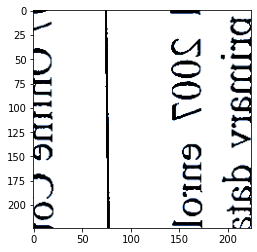

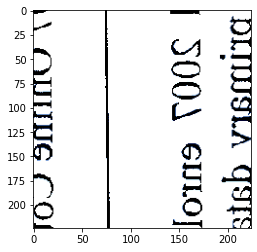

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(y_new[-1].swapaxes(0, 2))
plt.show()
plt.imshow(java_list)
plt.show()

In [ ]:
with open("final_img_data_2007.txt", "r") as f:
  lines = f.read()

In [ ]:
import ast

java_list = ast.literal_eval(lines)

In [ ]:
java_list = np.array(java_list, dtype = np.float32)